# Modeling
___

Below is a Random Forest Model using a Pipeline and Count Vectorization. Accuracy = %.

---

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

## Load the data
---

In [2]:
df = pd.read_csv('../../data/data_clean_combo_20220302-111425.csv')
df.drop(columns = 'Unnamed: 0', inplace=True)
df.head()

,author,title,selftext,created_utc,title_selftext,title_text_length,title_text_word_count,subreddit_target
0,RealDaveCorey,"Trying to straighten my leaning garage, was th...","Hi, I'm looking at torturing my leaning garage...",1645985955,trying to straighten my leaning garage wa the ...,1136,219,0
1,ZeroCool1,Thoughts from two years into purchasing a fixe...,A few random thoughts after I've wrestled with...,1645985873,thought from two year into purchasing a fixer ...,4077,816,0
2,gwenstellamade,HELP! Fireplace contractors screwed up the job,"So, I’m in a bit of a pickle with my current f...",1645985865,help fireplace contractor screwed up the jobso...,1795,351,0
3,happybaconbit,Kitchen cabinet track is broken. How do I fix it?,Photo: https://imgur.com/a/XgNq0iG \n\nIt’s be...,1645985826,kitchen cabinet track is broken how do i fix i...,248,55,0
4,stonetime10,OTR microwave with stud In the way,"Hello everyone,\nI am almost finished my basem...",1645985457,otr microwave with stud in the wayhello everyo...,709,139,0


## Create X and y
---

In [3]:
X = df['title_selftext']
X.head()

0    trying to straighten my leaning garage wa the ...
1    thought from two year into purchasing a fixer ...
2    help fireplace contractor screwed up the jobso...
3    kitchen cabinet track is broken how do i fix i...
4    otr microwave with stud in the wayhello everyo...
Name: title_selftext, dtype: object

In [4]:
y = df['subreddit_target']

## Baseline Accuracy
---

In [5]:
y.value_counts(normalize = True)

0    0.502137
1    0.497863
Name: subreddit_target, dtype: float64

It is essentially a 50/50 split. There is a slight preference towards HomeImprovement. So the baseline/null model will predict HomeImprovement and be accurate about 50% of the time. 

## Train - Test Split
---

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 33, stratify = y)

Want to keep the split to about 50/50 for the model, hence why this is being stratified.

## Pipeline/Vote
---
Will start with a pipeline including Count Vectorization and a logistic regresison model.

In [7]:
vote = VotingClassifier([
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('logreg', LogisticRegression(solver = 'liblinear')),
    ('forest', RandomForestClassifier())
])

pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('vote', vote)
])

## GridSearchCV
___

In [8]:
vote_params ={
     'vect__stop_words': [None, 'english'], 
     'vect__min_df': range(1, 10, 2), 
     'vect__max_df': [1.0, 0.75, 0.5, 0.25], #0.4, 0.3, 
     'vect__binary': [True, False],
#     'forest__n_estimators': [50, 75, 100, 125],
#     'forest__max_depth': [None, 3, 4, 5], 
#     'forest__max_features': ['auto']
}

rs = RandomizedSearchCV(pipe, param_distributions = vote_params)

rs.fit(X_train, y_train)
print(rs.best_score_) 
rs.best_params_

0.9436623835058964


{'vect__stop_words': None,
 'vect__min_df': 1,
 'vect__max_df': 0.25,
 'vect__binary': True}

## Model Evaluation
---

Using the GridSearch model above. 

In [9]:
y_pred = rs.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)

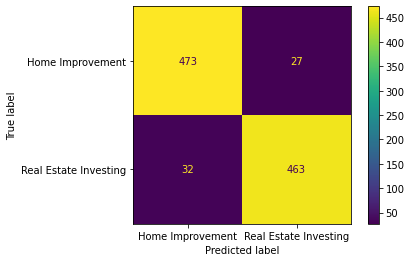

In [10]:
plot_confusion_matrix(rs, X_test, y_test, display_labels= ['Home Improvement', 'Real Estate Investing'])

The below function was created by Dennis T, a contributor on the Medium blog Towards Data Science. He explained in this [blog post](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea) how to use the code and supplied it [here](https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py).

In [11]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

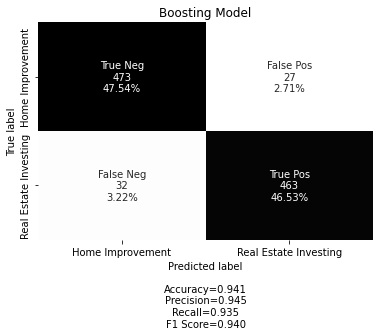

In [21]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Home Improvement', 'Real Estate Investing']

make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary',
                      cbar=False,
                     title = 'Boosting Model')

plt.savefig("../../images/boosting_matrix.jpg", bbox_inches="tight", dpi=100);

In [14]:
trainscore = rs.score(X_train, y_train)
testscore = rs.score(X_test, y_test)
crossval = cross_val_score(rs, X_train, y_train).mean()
preds = rs.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
recall = metrics.recall_score(y_test, preds)
precision = metrics.precision_score(y_test, preds)
accuracy = testscore
specificity = tn / (tn + fp)

print (f'Train Score = {trainscore}')
print (f'Test Score = {testscore}')
print (f'Cross Val Score = {crossval}')
print (f'Accuracy Score = {testscore}')
print (f'Recall Score = {recall}')
print (f'Precision Score = {precision}')
print (f'Specificity Score = {specificity}')

Train Score = 0.9785378940308518
Test Score = 0.9407035175879397
Cross Val Score = 0.9416489606871045
Accuracy Score = 0.9407035175879397
Recall Score = 0.9353535353535354
Precision Score = 0.9448979591836735
Specificity Score = 0.946


This model falls below the Logistic Regression Model in terms of Accuracy. The false negative and false positives are more balanced though.